<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

José Manuel Morales González
Rafael Turró Hidalgo
Xoel Gonzalo Otero

## Clasificación de expresiones faciales

#### Importación de las librerías:

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from random import seed
from random import randint
from keras import layers

import scipy.stats as stats
import cv2
from keras.utils import to_categorical

from skimage import feature
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize

from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import cross_validate

from keras.models import Sequential, Model
from keras import optimizers
from keras.applications import vgg16, mobilenet, resnet, xception
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, TrueNegatives, FalsePositives, AUC
from tensorflow.keras import callbacks

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

import warnings
warnings.filterwarnings('ignore')
import random
IMG_SIZE = 112


#### Declaración de funciones

####create_excel_file

In [112]:
def create_excel_file():
    cwd = os.getcwd()  # Obtiene el directorio de trabajo actual
    print("Directorio de trabajo:\n", cwd)
    file_path = os.path.join(cwd, "Metricas_CNN.xlsx")  # Ruta del archivo Excel
    if os.path.exists(file_path):
        print("El archivo ya existe en el directorio.")
    else:
        try:
            # Crear un archivo Excel vacío
            with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
                pass  # No hace nada, simplemente crea el archivo
            print("Archivo Excel creado exitosamente en el directorio.")
        except Exception as e:
            print("Error al crear el archivo Excel:", e)
    return os.path.exists(file_path)


#####append_data_to_excel

In [113]:
# Función para añadir datos a una tebla de excel
def append_data_to_excel(excel_name, df):
    with pd.ExcelWriter(excel_name,
        mode="a",
        engine="openpyxl",
        if_sheet_exists="overlay") as writer:
        start_row = 0
        header = True
        if os.path.exists(excel_name):
            df_source = pd.read_excel(excel_name, engine="openpyxl").iloc[:,1:]
        if df_source is not None:
            n, m = df_source.shape
            header = False if n > 0 else True
            start_row = n + 1 if n > 0 else n

        df.to_excel(writer, sheet_name="Sheet1",startcol=0, startrow = start_row, header=header)


####plot_history

In [114]:
# Función para graficar progreso durante el entrenamiento de la red
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label = 'Validación')
    plt.xlabel('Iteración (epoch)')
    plt.ylabel('Exactitud (accuracy)')
    plt.ylim([0, 1])
    plt.grid()
    #plt.title('Modelo '+str(i+1))
    plt.title('Modelo '+str(1))
    plt.legend(loc='lower right')

####load_data

In [115]:
def load_data(path):
  X, y = [], []
  #1205 es la menor cantidad de img en cada clase
  for label in CLASSES:
      for img in os.listdir(os.path.join(path, label))[:1205]: # OJO for img in os.listdir(os.path.join(path, label))[:1205]:
          full_path = os.path.join(path, label, img)
          image = cv2.imread(full_path)
          image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
          #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #verificar si las imagenes estan en rgb
          image = np.asarray(image).astype(np.float32) / 255.0
          X.append(image)
          y.append(CLASSES.index(label))

  y = to_categorical(y, num_classes=NUM_CLASSES)
  #y = np.argmax(y, axis=1)
  return np.array(X), np.array(y)


####Estrcuturas de las diferentes arquitecturas de CNN a implementar

In [116]:
#Distintas arquitectura para salida de la red neuronal
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical")
])
def cnn1(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    return model

def cnn2(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(classes, activation='softmax'))
    return model

def cnn3(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(classes, activation='softmax'))
    return model

def cnn4(NUM_CLASSES):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES))

    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

def get_base_model(name):
    if name == 'vgg':
        return vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    elif name == 'mobilnet':
        return mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    elif name == 'xception':
        return xception.Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    elif name == 'resnet50':
      return resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))


#### Carga de dataset desde Kaggle:

In [117]:
"""# Install Kaggle package
!pip install xlsxwriter
!pip install kaggle
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset
!unzip -q emotion-recognition-dataset.zip"""


'# Install Kaggle package\n!pip install xlsxwriter\n!pip install kaggle\nfrom google.colab import files\nuploaded = files.upload()\nfor fn in uploaded.keys():\n    print(f\'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes\')\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset\n!unzip -q emotion-recognition-dataset.zip'

#### Lectura de los datos y separación en datos de entrenamiento y test:

In [118]:
TRAIN_PATH = './dataset'
CLASSES = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
NUM_CLASSES = len(CLASSES)
print(CLASSES)

['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [119]:
X_train, y_train = load_data(TRAIN_PATH)
print(X_train.shape , y_train.shape)

(6025, 112, 112, 3) (6025, 5)


In [120]:
train_images , test_images , train_labels , test_labels = train_test_split(X_train, y_train, test_size=0.3,shuffle=True)

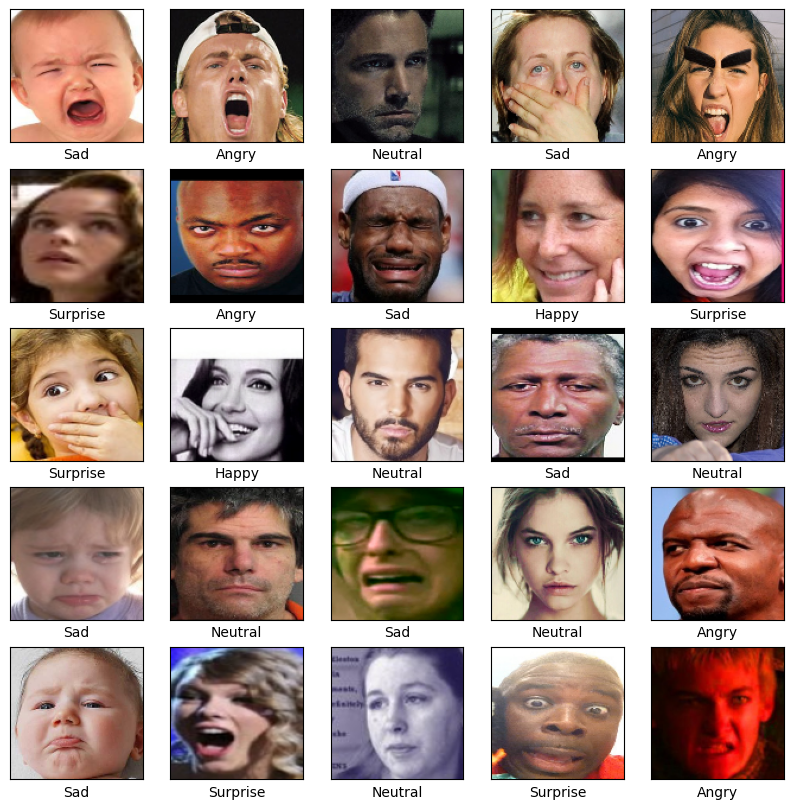

In [121]:
y_train_labels = np.argmax(train_labels, axis=1)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(CLASSES[y_train_labels[i]])

#### Se importa la red CNN VGG16 para utilizar su arquitectura y conocimento para resolver nuestro problema

In [122]:
# include top should be False to remove the softmax layer
"""model_name = "vgg"
pretrained_model = get_base_model(model_name)
pretrained_model.summary()"""

'model_name = "vgg"\npretrained_model = get_base_model(model_name)\npretrained_model.summary()'

In [123]:
"""model_name = "mobilnet"
pretrained_model = get_base_model(model_name)
pretrained_model.summary()"""

'model_name = "mobilnet"\npretrained_model = get_base_model(model_name)\npretrained_model.summary()'

In [124]:
model_name = "xception"
pretrained_model = get_base_model(model_name)
pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 55, 55, 32)           864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 55, 55, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 55, 55, 32)           0         ['block1_conv1_bn[0][0]

In [125]:
input_shape = pretrained_model.output_shape[1:4]
modelCNN = cnn1(input_shape, NUM_CLASSES)
modelCNN.compile(optimizer='adam', metrics=['accuracy',
                                            tf.keras.metrics.Recall(),
                                            tf.keras.metrics.TrueNegatives(),
                                            tf.keras.metrics.FalsePositives(),
                                            tf.keras.metrics.Precision(),
                                            tf.keras.metrics.AUC()], loss='categorical_crossentropy')
modelCNN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                2097216   
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2097541 (8.00 MB)
Trainable params: 2097541 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Entrenamiento con tecnica FINE-TUNNING

57/57 [==============================] - 2s 31ms/step
Epoch 1/100
85/85 [==============================] - 2s 26ms/step - loss: 0.8296 - accuracy: 0.6628 - recall_5: 0.5046 - true_negatives_2: 16277.0000 - false_positives_2: 591.0000 - precision_5: 0.7826 - auc_5: 0.9128 - val_loss: 1.4299 - val_accuracy: 0.4834 - val_recall_5: 0.3700 - val_true_negatives_2: 6690.0000 - val_false_positives_2: 542.0000 - val_precision_5: 0.5524 - val_auc_5: 0.7836
Epoch 2/100
85/85 [==============================] - 1s 11ms/step - loss: 0.7746 - accuracy: 0.6815 - recall_5: 0.5438 - true_negatives_2: 16250.0000 - false_positives_2: 618.0000 - precision_5: 0.7877 - auc_5: 0.9240 - val_loss: 1.4025 - val_accuracy: 0.4856 - val_recall_5: 0.3728 - val_true_negatives_2: 6732.0000 - val_false_positives_2: 500.0000 - val_precision_5: 0.5741 - val_auc_5: 0.7901
Epoch 3/100
85/85 [==============================] - 1s 12ms/step - loss: 0.7116 - accuracy: 0.7081 - recall_5: 0.5907 - true_negatives_2: 16302.0000 - 

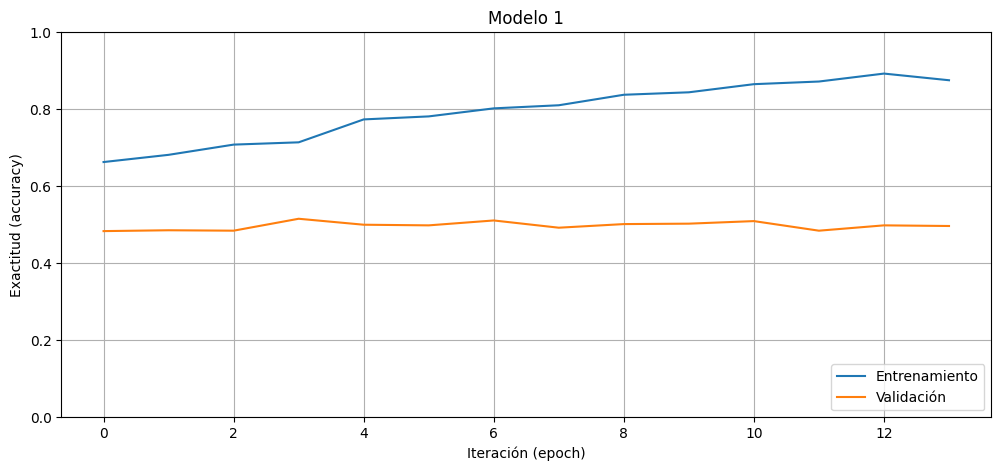

In [138]:
# train model using features generated from VGG16 model
epochs = 100
batch_size = 50
n_iter_no_change = 10
f1_score, time_ = [[] for _ in range(2)]

earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', verbose = 1, restore_best_weights = True, patience=n_iter_no_change)

#Se entrena el modelo
tic = time.perf_counter()
features_train = pretrained_model.predict(train_images)
features_test = pretrained_model.predict(test_images)
history = (modelCNN.fit(features_train, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(features_test, test_labels),callbacks = [earlystop_callback] ))
toc = time.perf_counter()
train_time = round((toc-tic), 2)

# Se evalua el modelo segun algunas metricas de error
tic = time.perf_counter()
test_loss, test_acc, test_recall, true_neg, false_pos, test_prec, test_auc = modelCNN.evaluate(features_test,  test_labels, verbose=0)
print('Accuray (test)', test_acc)
toc = time.perf_counter()
eval_time = round((toc-tic), 2)

f1_score.append(round(2 * test_recall * test_prec / (test_recall + test_prec),2)
                if (test_recall + test_prec) > 0 else 0)

test_data = {
        'base model'    : pretrained_model.name,
        'out layers'    : len(modelCNN.layers),
        'extra params'  : modelCNN.count_params(),
        'epochs'        : epochs,
        'batch size'    : batch_size,
        'accuracy'      : round(test_acc,2),
        'recall'        : round(test_recall,2),
        'specificity'   : round(true_neg/(true_neg + false_pos),2),
        'precision'     : round(test_prec,2),
        'f1_score'      : f1_score,
        'auc'           : round(test_auc,2),
        'train time'    : train_time,
        'eval time'     : eval_time
        }

now = datetime.now() # current date and time
time_.append(now.strftime("%d/%m/%Y %H:%M:%S"))
df = pd.DataFrame(test_data, index = time_)
create_excel_file()
excel_name = "./Metricas_CNN.xlsx"
append_data_to_excel(excel_name, df)

print(df)
plot_history(history)

#### Se puede calcular la matriz de confusión de la red

1/1 [==============================] - 0s 19ms/step


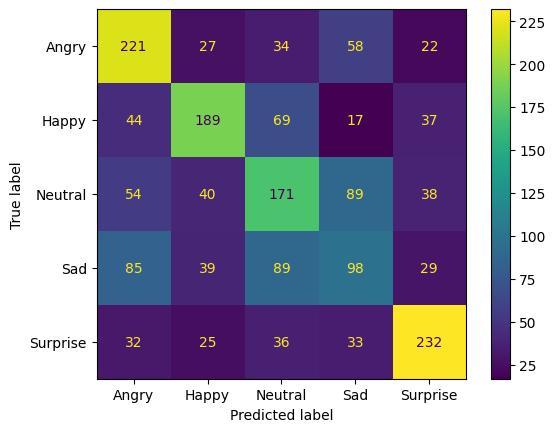

In [127]:
t_test_ = np.argmax(test_labels, axis=1)
features_test = pretrained_model.predict(test_images.reshape(len(test_images),IMG_SIZE,IMG_SIZE,3))
t_pred = []
for i in range(0,len(features_test)):
    t_pred.append(np.argmax(modelCNN.predict(features_test[i:i+1])))
cm = confusion_matrix(t_test_, t_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=CLASSES)
disp.plot()

In [128]:
print(features_test.shape , len(t_pred))
print(t_test_.shape ,  len(t_pred))

(1808, 4, 4, 2048) 1808
(1808,) 1808


1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms

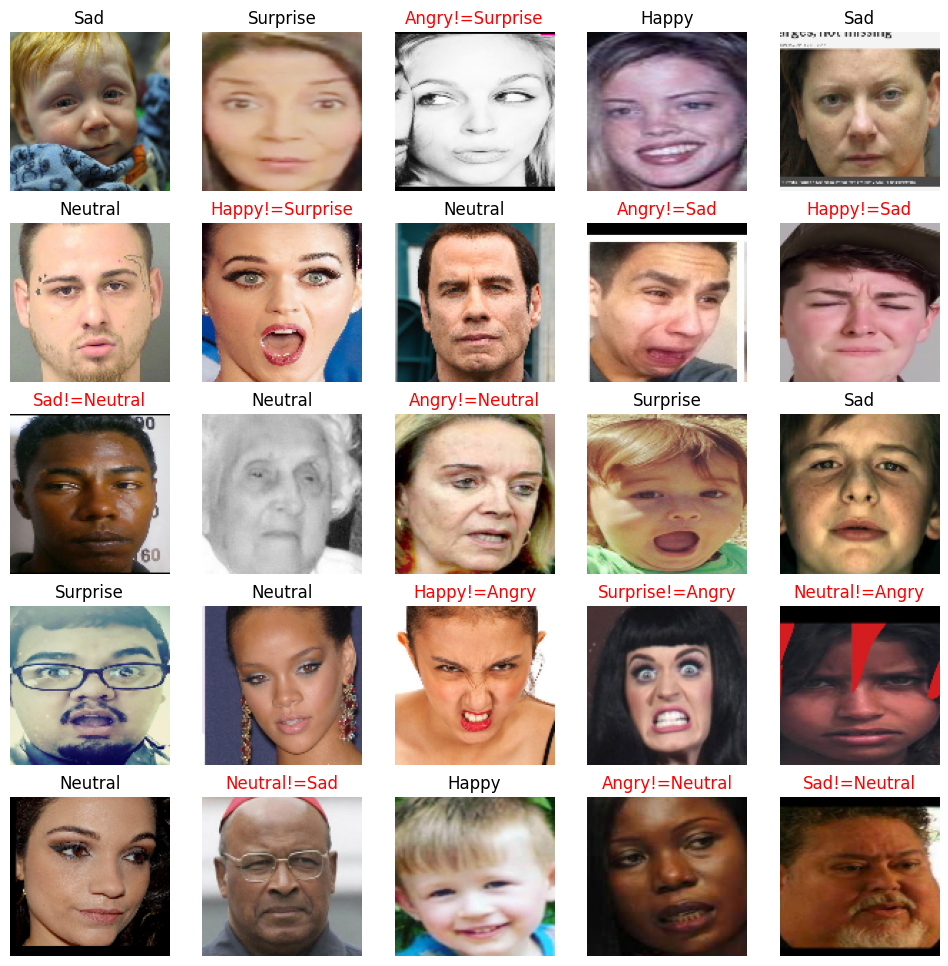

In [129]:
test_labels_ = np.argmax(test_labels, axis=1)
plt.figure(figsize=(12,12))
for i in range(25):
    index = random.randint(0, test_images.shape[0]) # Se elige un número de imagen al azar
    image = test_images[index:index+1]

    plt.subplot(5, 5, i+1)
    plt.imshow(image[0])       # Se muestra la imagen elegida al azar
    plt.axis('off')

    feature = pretrained_model.predict(np.expand_dims(image[0], axis=0))  # Asegúrate de que la imagen tiene una dimensión extra para el lote (batch)
    class_pred = np.argmax(modelCNN.predict(feature))

    if test_labels_[index] == class_pred:   # Si hay acierto en la clase predicha: se muestra en el título solo el nombre de clase
        print()
        plt.title(CLASSES[class_pred])
    else:                                  # Si hay un error en la clasificación: se muestra en rojo en el título ambas clases
        print()
        plt.title(CLASSES[class_pred] + "!=" + CLASSES[test_labels_[index]], color='#ff0000')

#Entrenamiento modelo CNN_4

In [130]:
model4 = cnn4(NUM_CLASSES)
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 flatten_5 (Flatten)         (None, 36864)            

Epoch 1/100
43/43 [==============================] - 3s 66ms/step - loss: 1.5973e-05 - accuracy: 1.0000 - val_loss: 6.1209 - val_accuracy: 0.5531
Epoch 2/100
43/43 [==============================] - 2s 41ms/step - loss: 1.5408e-05 - accuracy: 1.0000 - val_loss: 6.1364 - val_accuracy: 0.5548
Epoch 3/100
43/43 [==============================] - 2s 42ms/step - loss: 1.4962e-05 - accuracy: 1.0000 - val_loss: 6.1556 - val_accuracy: 0.5559
Epoch 4/100
43/43 [==============================] - 2s 43ms/step - loss: 1.4336e-05 - accuracy: 1.0000 - val_loss: 6.1703 - val_accuracy: 0.5537
Epoch 4: early stopping
57/57 [==============================] - 0s 6ms/step
Directorio de trabajo:
 /content
El archivo ya existe en el directorio.
                    base model out layers  extra params  epochs  batch size  \
10/03/2024 03:23:58       cnn4          3       2416005     100         100   

                     accuracy  recall  specificity  precision  f1_score   auc  \
10/03/2024 03:23:58      0.

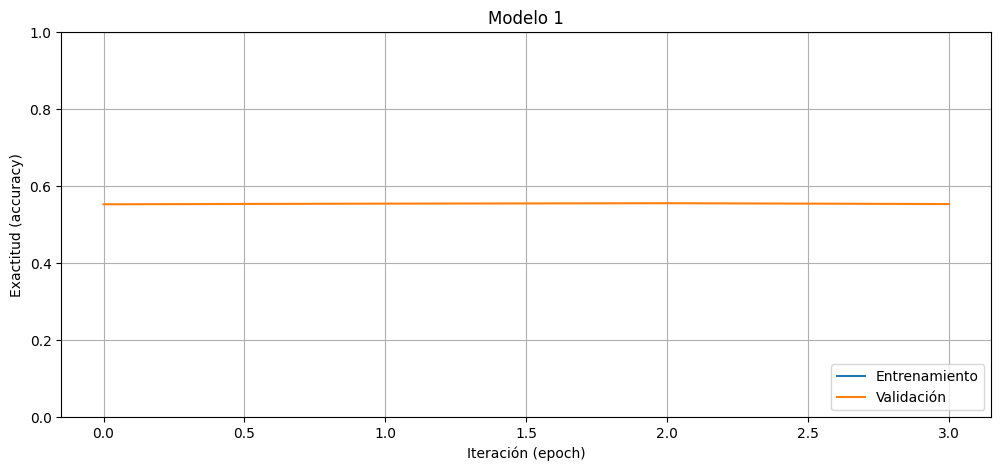

In [137]:
# Entrenamiento CNN_4
epochs = 100
batch_size = 100
history , time_ = [[] for _ in range(2)]  #se crean dos listas vacias

min_delta = 0.5  # Definir el mínimo cambio deseado en la métrica

earlystop_callback = callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, patience=n_iter_no_change, min_delta=min_delta)
#earlystop_callback = callbacks.EarlyStopping(monitor='val_accuracy', verbose = 1, restore_best_weights = True, patience=n_iter_no_change)

train_labels_ = np.argmax(train_labels, axis=1)
test_labels_  = np.argmax(test_labels , axis=1)

tic_train = time.time()
history = model4.fit(train_images, train_labels_, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels_) , callbacks = [earlystop_callback])
toc_train = time.time()
train_time = toc_train - tic_train

# Evaluación
tic_eval = time.time()
test_pred_probs = model4.predict(test_images)
test_pred = np.argmax(test_pred_probs, axis=1)
toc_eval = time.time()
eval_time = toc_eval - tic_eval

# Métricas
accuracy = accuracy_score(test_labels_, test_pred)
recall = tf.keras.metrics.Recall()(test_labels_, test_pred).numpy()
precision = tf.keras.metrics.Precision()(test_labels_, test_pred).numpy()
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = tf.keras.metrics.SpecificityAtSensitivity(0.5)(test_labels, test_pred_probs).numpy() #este valor se ajusta SpecificityAtSensitivity(0.5)
auc = tf.keras.metrics.AUC()(test_labels, test_pred_probs).numpy()

test_data = {
        'base model'    : "cnn4",
        'out layers'    : "3",  #estas son las tres utlias capas de la estrcutura de la red que escogimos
        'extra params'  : model4.count_params(),
        'epochs'        : epochs,
        'batch size'    : batch_size,
        'accuracy'      : round(accuracy,2),
        'recall'        : round(recall,2),
        'specificity'   : round(specificity,2),
        'precision'     : round(precision,2),
        'f1_score'      : round(f1_score,2),
        'auc'           : round(auc,2),
        'train time'    : round(train_time,2),
        'eval time'     : round(eval_time,2)
        }

now = datetime.now() # current date and time
time_.append(now.strftime("%d/%m/%Y %H:%M:%S"))
df = pd.DataFrame(test_data, index = time_)
create_excel_file()
excel_name = "./Metricas_CNN.xlsx"
append_data_to_excel(excel_name, df)

print(df)
plot_history(history)


57/57 [==============================] - 0s 7ms/step


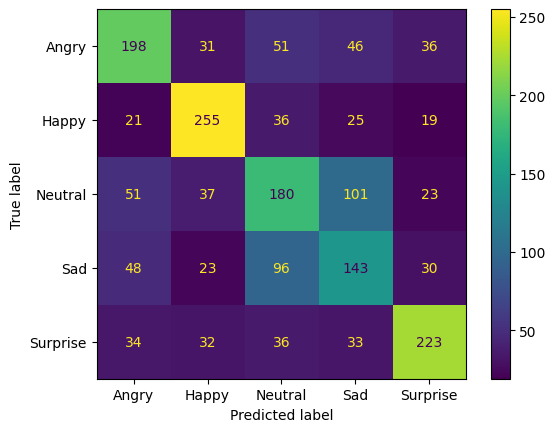

In [133]:
t_pred = model4.predict(test_images)
t_pred_ = np.argmax(t_pred , axis=1)
cm = confusion_matrix(t_test_, t_pred_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=CLASSES)
disp.plot()

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms

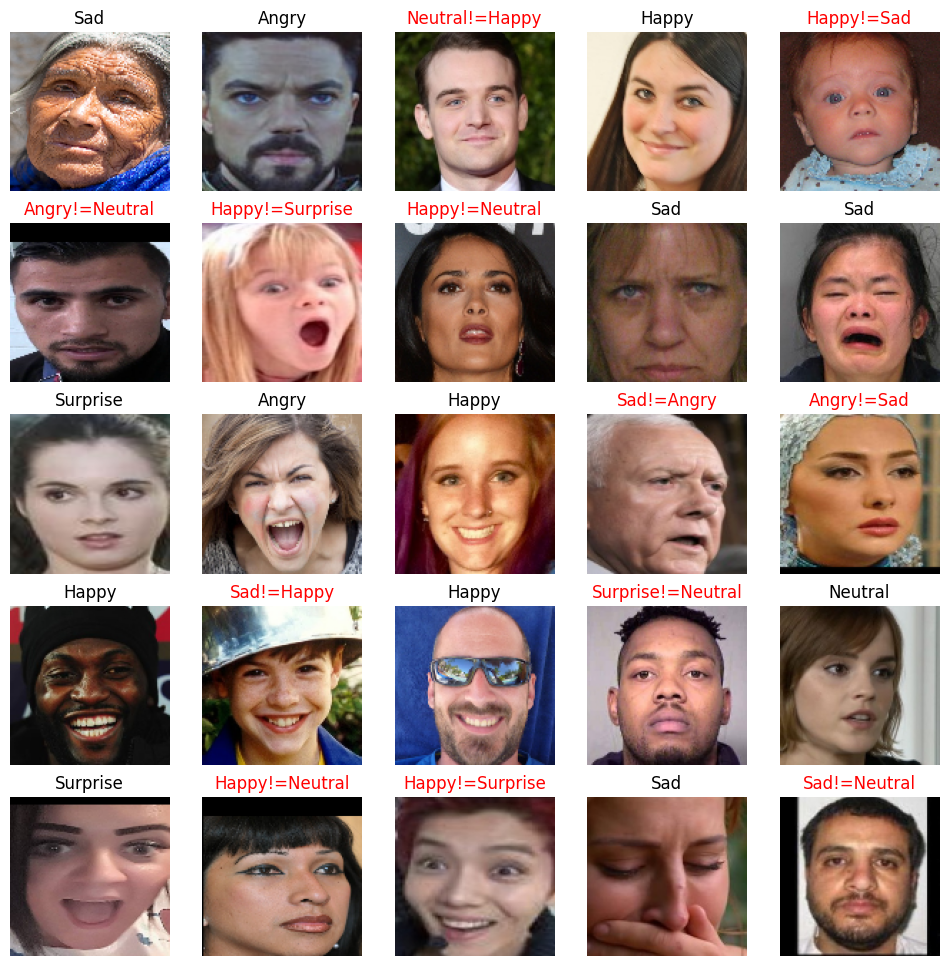

In [134]:
test_labels_ = np.argmax(test_labels, axis=1)
plt.figure(figsize=(12,12))
for i in range(25):
    index = random.randint(0, test_images.shape[0]) # Se elige un número de imagen al azar
    image = test_images[index:index+1]

    plt.subplot(5, 5, i+1)
    plt.imshow(image[0])       # Se muestra la imagen elegida al azar
    plt.axis('off')

    pred = model4.predict(image)  # Se obtiene la predicción del modelo para la imagen elegida
    class_pred = np.argmax(pred)

    if test_labels_[index] == class_pred:   # Si hay acierto en la clase predicha: se muestra en el título solo el nombre de clase
        print()
        plt.title(CLASSES[class_pred])
    else:                                  # Si hay un error en la clasificación: se muestra en rojo en el título ambas clases
        print()
        plt.title(CLASSES[class_pred] + "!=" + CLASSES[test_labels_[index]], color='#ff0000')